<a href="https://colab.research.google.com/github/DmitryKutsev/NIS_SentiFrame/blob/master/fasttext_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [0]:
senti_df = pd.read_csv(\
    'https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/annotations/SENTIFRAME%20-%20case_annotation.csv')

In [53]:
senti_df

,verb,polar_or_not,polarity_dima,polarity_ira,polarity_masha,"падеж первого аргумента, по умолчанию nomn","падеж второго аргумента в нотации pymorphy2, по умолчанию accs",Комментарий,"""Класс""","rel(А0,A1)","rel(А1,A0)"
0,арестовать,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
1,арестовывать,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
2,атаковать,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
3,беречь,3,1,1,1,NaN,accs,NaN,NaN,NaN,NaN
4,беспокоить,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
440,шантажировать,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
441,шокировать,3,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
442,штурмовать,6,0,0,0,NaN,accs,NaN,NaN,NaN,NaN
443,эксплуатировать,3,0,0,0,NaN,accs,NaN,NaN,NaN,NaN


In [0]:
senti_df['polarity_summ'] = senti_df['polarity_masha'] + senti_df['polarity_dima'] + senti_df['polarity_ira']

In [0]:
my_senti_df = senti_df.drop(['polarity_dima', 'polarity_masha', 'polarity_ira', 'падеж первого аргумента, по умолчанию nomn', '"Класс"','rel(А0,A1)','rel(А1,A0)'], axis=1)

In [0]:
my_senti_df['падеж второго аргумента в нотации pymorphy2'] = my_senti_df['падеж второго аргумента в нотации pymorphy2, по умолчанию accs']

In [78]:
my_senti_df = my_senti_df.drop(['падеж второго аргумента в нотации pymorphy2, по умолчанию accs'], axis=1)
my_senti_df = my_senti_df.drop(['Комментарий'], axis=1)
my_senti_df

,verb,polar_or_not,polarity_summ,падеж второго аргумента в нотации pymorphy2
0,арестовать,6,0,accs
1,арестовывать,6,0,accs
2,атаковать,6,0,accs
3,беречь,3,3,accs
4,беспокоить,6,0,accs
...,...,...,...,...
440,шантажировать,6,0,accs
441,шокировать,3,0,accs
442,штурмовать,6,0,accs
443,эксплуатировать,3,0,accs


In [58]:
#tayga_none_fasttextcbow_300_10_2019

!wget http://vectors.nlpl.eu/repository/20/187.zip

--2020-05-15 19:30:38--  http://vectors.nlpl.eu/repository/20/187.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2692389554 (2.5G) [application/zip]
Saving to: ‘187.zip.1’

187.zip.1             0%[                    ]   1.63M   958KB/s               ^C


In [59]:
!unzip 187.zip

Archive:  187.zip
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
!wget http://vectors.nlpl.eu/repository/20/181.zip

--2020-05-15 18:08:46--  http://vectors.nlpl.eu/repository/20/181.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2622716250 (2.4G) [application/zip]
Saving to: ‘181.zip’

181.zip             100%[===================>]   2.44G  21.7MB/s    in 2m 2s   

2020-05-15 18:10:49 (20.5 MB/s) - ‘181.zip’ saved [2622716250/2622716250]



In [16]:
fasttext_model = gensim.models.KeyedVectors.load("model.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
!unzip 181.zip

Archive:  181.zip
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  y

  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


In [20]:
fasttext_model2 = gensim.models.KeyedVectors.load("model.model")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
!wget https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json

--2020-05-15 18:10:54--  https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 674938 (659K) [text/plain]
Saving to: ‘collection.json’

collection.json     100%[===================>] 659.12K  --.-KB/s    in 0.09s   

2020-05-15 18:10:54 (7.03 MB/s) - ‘collection.json’ saved [674938/674938]



In [13]:
!pip install pymorphy2[fast]

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 7.1MB 7.8MB/s 
     |████████████████████████████████| 378kB 44.4MB/s 
  Created wheel for DAWG: filename=DAWG-0.8.0-cp36-cp36m-linux_x86_64.whl size=860902 sha256=b8c1c679bfeaafe41903db68cb68d9772434fa6fa1461f5cba376584085ba3b2
  Stored in directory: /root/.cache/pip/wheels/3d/1f/f0/a5b1f9d02e193c997d252c33d215f24dfd7a448bc0166b2a12
Successfully built DAWG


In [0]:
from collections import Counter
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
import pymorphy2
import gensim
morph = pymorphy2.MorphAnalyzer()

In [0]:
positive_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить']
negative_multi_seed = ['ненавидеть', 'убить', 'ругать', 'злиться']
positive_single_seed = ['ценить']
negative_single_seed = ['ненавидеть']

In [0]:
def make_seed_embedding(seed_dict, model):
  '''
  Принимает на вход список, на выходе дает средний вектор всех слов из этого списка
  '''
  summ = 0
  for verb in seed_dict:
    summ = summ + model.get_vector(verb)
  vector = summ/len(seed_dict)

  return vector

positive_multi_embedding = make_seed_embedding(positive_multi_seed, fasttext_model)
negative_multi_embedding = make_seed_embedding(negative_multi_seed, fasttext_model)

positive_multi_embedding2 = make_seed_embedding(positive_multi_seed, fasttext_model2)
negative_multi_embedding2 = make_seed_embedding(negative_multi_seed, fasttext_model2)

In [0]:
axis = positive_multi_embedding  - negative_multi_embedding
axis2 = positive_multi_embedding2  - negative_multi_embedding2

In [140]:
cosine_similarity(np.atleast_2d(fasttext_model.get_vector('беречь')), np.atleast_2d(axis))[0][0]

0.055182472

In [94]:
cosine_similarity(np.atleast_2d(fasttext_model2.get_vector('беречь')), np.atleast_2d(axis2))[0][0]

-0.022619711

In [95]:
cosine_similarity(np.atleast_2d(fasttext_model.get_vector('арестовывать')), np.atleast_2d(axis))[0][0]

-0.047116164

In [96]:
cosine_similarity(np.atleast_2d(fasttext_model2.get_vector('арестовывать')), np.atleast_2d(axis2))[0][0]

-0.16251335

In [0]:
fasttext_pol = []
cosine_lst = []
manual_pol = []
treshold = 0.03
for i in range(len(my_senti_df['verb'])):
  cosine = cosine_similarity(np.atleast_2d(fasttext_model.get_vector(my_senti_df['verb'][i])), \
                             np.atleast_2d(axis))
  if cosine >= treshold:
    fasttext_pol.append(1)
  else:
    fasttext_pol.append(0)
  cosine_lst.append(cosine[0][0])
  if my_senti_df['polarity_summ'][i] > 1:
    manual_pol.append(1)
  else:
    manual_pol.append(0)
my_senti_df['fasttext_polarity'] = fasttext_pol
my_senti_df['manual_polarity'] = manual_pol
my_senti_df['cosine_distance'] = cosine_lst

  

In [106]:
fasttext_pol2 = []
cosine_lst2 = []
not_in_model2 = []
treshold = 0.03
for i in range(len(my_senti_df['verb'])):
  try:
    cosine = cosine_similarity(np.atleast_2d(fasttext_model2.get_vector(my_senti_df['verb'][i])),\
                              np.atleast_2d(axis2))
    if cosine >= treshold:
      fasttext_pol2.append(1)
    else:
      fasttext_pol2.append(0)
    cosine_lst2.append(cosine[0][0])
  except AttributeError as e:
    not_in_model2.append([i])


my_senti_df['cosine_distance2'] = cosine_lst2
my_senti_df['fasttext_polarity2'] = fasttext_pol2
print(len(not_in_model2))
for i in not_in_model2:
  print(i)
  my_senti_df = my_senti_df.drop(i)



0


In [107]:
print(len(fasttext_model2.vocab))
len(fasttext_model.vocab)

164996


192415

In [108]:
#my_senti_df = my_senti_df.drop([444])
my_senti_df

,verb,polar_or_not,polarity_summ,падеж второго аргумента в нотации pymorphy2,fasttext_polarity,manual_polarity,cosine_distance,cosine_distance2,fasttext_polarity2
0,арестовать,6,0,accs,0,0,-0.045196,-0.159426,0
1,арестовывать,6,0,accs,0,0,-0.047116,-0.162513,0
2,атаковать,6,0,accs,0,0,-0.170026,-0.109497,0
3,беречь,3,3,accs,1,1,0.055182,-0.022620,0
4,беспокоить,6,0,accs,0,0,-0.252901,-0.122636,0
...,...,...,...,...,...,...,...,...,...
439,чаять,1,3,datv,0,1,-0.019511,0.038460,1
440,шантажировать,6,0,accs,0,0,-0.049897,-0.068322,0
441,шокировать,3,0,accs,0,0,-0.043513,0.026868,0
442,штурмовать,6,0,accs,0,0,-0.095362,-0.086980,0


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from matplotlib import pyplot

In [110]:
my_senti_df['fasttext_polarity'].value_counts()

0    333
1    111
Name: fasttext_polarity, dtype: int64

In [111]:
my_senti_df['manual_polarity'].value_counts()

0    321
1    123
Name: manual_polarity, dtype: int64

In [112]:
acc = accuracy_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity'])
micro_f1 = f1_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity'], average = None)
micro_p = precision_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity'], average = None)
micro_r = recall_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity'], average = None)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, precision={1:1.4f}, recall={2:1.4f}'.format(micro_f1[-1], micro_p[-1], micro_r[-1]))

acc=0.8063
F1=0.6325, precision=0.6667, recall=0.6016


In [113]:
acc = accuracy_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity2'])
micro_f1 = f1_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity2'], average = None)
micro_p = precision_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity2'], average = None)
micro_r = recall_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity2'], average = None)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, precision={1:1.4f}, recall={2:1.4f}'.format(micro_f1[-1], micro_p[-1], micro_r[-1]))

acc=0.7950
F1=0.6286, precision=0.6311, recall=0.6260


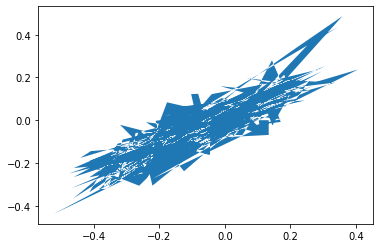

In [116]:
plt.stackplot(my_senti_df['cosine_distance'], my_senti_df['cosine_distance2'])

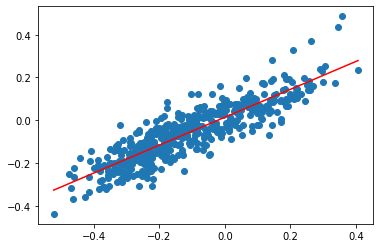

In [121]:
x = my_senti_df['cosine_distance']
y = my_senti_df['cosine_distance2']
plt.scatter(my_senti_df['cosine_distance'], my_senti_df['cosine_distance2'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
plt.show()

In [0]:
from scipy.stats.stats import pearsonr

In [126]:
pearsonr(x,y)

(0.876644294617535, 1.5829666998843536e-142)

In [0]:
from scipy.stats import spearmanr
#https://www.machinelearningmastery.ru/how-to-calculate-nonparametric-rank-correlation-in-python/

In [124]:
spearmanr(x, y)

SpearmanrResult(correlation=0.8806826711562044, pvalue=1.618416436974419e-145)

In [0]:
#больше моделей богу моделей

In [131]:
!wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2020-05-15 20:46:57--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  26.7MB/s    in 99s     

2020-05-15 20:48:37 (26.0 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



In [0]:
!tar -xzf araneum_none_fasttextcbow_300_5_2018.tgz

In [135]:
fasttext_model3 = gensim.models.KeyedVectors.load("araneum_none_fasttextcbow_300_5_2018.model")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
positive_multi_embedding3 = make_seed_embedding(positive_multi_seed, fasttext_model3)
negative_multi_embedding3 = make_seed_embedding(negative_multi_seed, fasttext_model3)

axis3 = positive_multi_embedding3  - negative_multi_embedding3

In [146]:
fasttext_pol3 = []
cosine_lst3 = []
not_in_model3 = []
treshold = 0.03
for i in range(len(my_senti_df['verb'])):
  try:
    cosine = cosine_similarity(np.atleast_2d(fasttext_model3.get_vector(my_senti_df['verb'][i])),\
                              np.atleast_2d(axis3))
    if cosine >= treshold:
      fasttext_pol3.append(1)
    else:
      fasttext_pol3.append(0)
    cosine_lst3.append(cosine[0][0])
  except AttributeError as e:
    not_in_model3.append([i])



print(len(not_in_model3))
# в этой модели не находит аж 146 глаголов!
for i in not_in_model3:
  my_senti_df = my_senti_df.drop(i)
my_senti_df['cosine_distance3'] = cosine_lst3
my_senti_df['fasttext_polarity3'] = fasttext_pol3

0


In [147]:
my_senti_df

,verb,polar_or_not,polarity_summ,падеж второго аргумента в нотации pymorphy2,fasttext_polarity,manual_polarity,cosine_distance,cosine_distance2,fasttext_polarity2,cosine_distance3,fasttext_polarity3
1,арестовывать,6,0,accs,0,0,-0.047116,-0.162513,0,-0.156715,0
2,атаковать,6,0,accs,0,0,-0.170026,-0.109497,0,-0.305128,0
3,беречь,3,3,accs,1,1,0.055182,-0.022620,0,-0.137536,0
4,беспокоить,6,0,accs,0,0,-0.252901,-0.122636,0,-0.336846,0
5,бить,6,0,accs,0,0,-0.356272,-0.270132,0,-0.474794,0
...,...,...,...,...,...,...,...,...,...,...,...
439,чаять,1,3,datv,0,1,-0.019511,0.038460,1,-0.264535,0
440,шантажировать,6,0,accs,0,0,-0.049897,-0.068322,0,-0.108525,0
441,шокировать,3,0,accs,0,0,-0.043513,0.026868,0,-0.152533,0
442,штурмовать,6,0,accs,0,0,-0.095362,-0.086980,0,-0.225143,0


In [148]:
acc = accuracy_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity3'])
micro_f1 = f1_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity3'], average = None)
micro_p = precision_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity3'], average = None)
micro_r = recall_score(my_senti_df['manual_polarity'], my_senti_df['fasttext_polarity3'], average = None)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, precision={1:1.4f}, recall={2:1.4f}'.format(micro_f1[-1], micro_p[-1], micro_r[-1]))

acc=0.7987
F1=0.5522, precision=0.8043, recall=0.4205


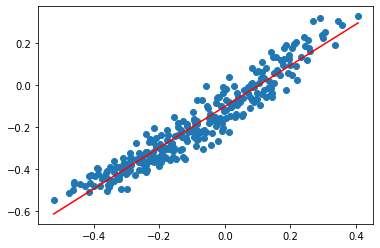

In [149]:
x = my_senti_df['cosine_distance']
y = my_senti_df['cosine_distance3']
plt.scatter(my_senti_df['cosine_distance'], my_senti_df['cosine_distance3'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
plt.show()

In [150]:
pearsonr(x,y)
# 3я модель и хуже отработала, и глаголов ужасно много порезала, но с 1й
# кореллирует лучше, потому что методы одинаковые, а разные только корпусы

(0.9579081098221475, 1.7827948656592518e-162)

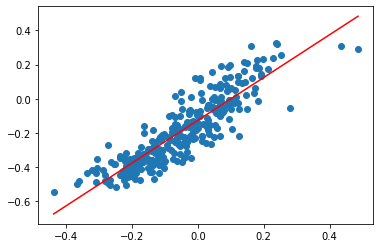

In [151]:
x = my_senti_df['cosine_distance2']
y = my_senti_df['cosine_distance3']
plt.scatter(my_senti_df['cosine_distance2'], my_senti_df['cosine_distance3'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
plt.show()

In [152]:
pearsonr(x,y)

(0.8867726476479408, 3.2286190510991494e-101)